## Financial Programming - Individual Project

Text Analysis US Stocks

MBD 2019

Alejandra Zambrano

### 1. Import Libraries

In [75]:
import os
import re
import tweepy
import string
import nltk
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from tweepy import Stream
from textblob import TextBlob
from tweepy import OAuthHandler
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tweepy.streaming import StreamListener
from nltk.probability import FreqDist

### 2. Access Twitter API

In [2]:
# Keys and access tokens

consumer_key = "nKZ5FTTzaCR1aKP1iNpmIn6Vu"
consumer_secret = "2XpBOAqgMRLimIa8bmfaD98BgmRtPX8zqyokjoV888RRr6tFFm"
access_token = "3389686869-gKStw1eqa0jqzLCv5Tk8x9zjLIbAMKPGefzwjXX"
access_token_secret = "0KcuwyfjGUhMNP0kBZvwYu3AjbOtNE0evjA74usKYKvdh"

# Authentication

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# API

api = tweepy.API(auth,wait_on_rate_limit=True)

### 3. Reading Tweets Stocks

In [3]:
# Defining a function for getting tweets

def get_tweets(keyword, dateSince ):

# Getting only original tweets (no retweets) 

    keyword= keyword + ' -filter:retweets'
    
    dict_ = {'user': [], 'created_at': [], 'text': [], 'location': [], 'retweet_count': [], 'favorite_count': []}

    for tweet in tweepy.Cursor(api.search, q=keyword, lang="en", since=dateSince).items():
        
        dict_['user'].append(tweet.user.screen_name)
        dict_['created_at'].append(tweet.created_at)
        dict_['text'].append(tweet.text)
        dict_['location'].append(tweet.user.location)
        dict_['retweet_count'].append(tweet.retweet_count)
        dict_['favorite_count'].append(tweet.favorite_count)
        
# Structure data in a DataFrame

    df = pd.DataFrame(dict_)
    return df

### 4. Cleaning Process

In [4]:
# Defining a function for cleaning the data

def cleaning_data(df,stopWords):
    
# Removing URLs, "|", "\n", @ mentions, #, multiple white spaces,numbers. Converting text into lowercase   

    df['text_clean'] = df.text.apply( lambda x: re.sub(r"(?:\@|https?\://)\S+", "",x)).str.lower()
    df['text_clean'] = df.text_clean.apply(lambda x: re.sub("|", "",x))
    df['text_clean'] = df.text_clean.apply(lambda x: re.sub("\n", "",x))
    df['text_clean'] = df.text_clean.apply(lambda x: re.sub(r"\d", "", x))
    df['text_clean'] = df.text_clean.apply(lambda x: re.sub(r"#","", x, flags=re.MULTILINE))
    df['text_clean'] = df.text_clean.apply(lambda x: re.sub(r'[^\x00-\x7F]+',"", x))
    df['text_clean'] = df.text_clean.apply(lambda x:' '.join(x.split()))
    
#  Removing other punctuations

    punctuations = '''!()-![]{};:+'"\,<>./?@#$%^&*_~‘’“”'''
    
    def remove_punct(text):
        text  = "".join([char for char in text if char not in punctuations])
        return text

    df['text_clean'] = df.text_clean.apply(lambda x: remove_punct(x))
    
# Removing emojis

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF" 
        u"\U0001F680-\U0001F6FF" 
        u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags=re.UNICODE)
    
    df["text_clean"]=df.text_clean.apply(lambda x: emoji_pattern.sub(r'', x))
    
# Applying stop words and removing short words

    stop_words = stopwords.words('english')
    total_stop_words=stop_words+stopWords
    df['text_clean']=df.text_clean.apply(lambda x: ' '.join([word for word in x.split() 
                                                    if word not in (total_stop_words)]))
    df['text_clean'] = df.text_clean.apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

    return df

### 5. Text Analysis

##### Common Words

In [5]:
# Defining a function to get the common words by stock

def common_words(df):

# Joining all tweets in a single list and tokenization

    total_text = " ".join(text_tweet for text_tweet in df.text_clean)
    tokenized_word= word_tokenize(total_text)
    
# Frequency distribution words

    fdist = FreqDist(tokenized_word)
    df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
    df_fdist.columns = ['Frequency']
    df_fdist.index.name = 'Term'
    df_fdist=df_fdist.sort_values('Frequency', ascending=False)
    plt.figure(figsize=(10,5))
    fdist.plot(30,cumulative=False)
    plt.show()
    
    return df_fdist[:10]

##### Word Cloud

In [6]:
# Defining a function to plot the Word Cloud

def wordCloud(df,stopWords):
    
    stop_words = stopwords.words('english')
    total_stop_words=stop_words+stopWords
    

# Generate a word cloud image and joining all tokenized words in a single list

    total_text = " ".join(text_tweet for text_tweet in df.text_clean)
    tokenized_word= word_tokenize(total_text)

    join_words = " ".join(text_tweet for text_tweet in tokenized_word)
    wordcloud = WordCloud(width=1600, height=800, stopwords=total_stop_words, background_color="white").generate(join_words)

# Display word cloud:

    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

##### Sentimental Analysis

In [57]:
# Defining a function to get Sentimental Analysis by stock

def sentimentalAnalysis(df):

    # Applying TextBlob for getting sentimental analysis

    sentiment_objects = [TextBlob(tweet) for tweet in df.text_clean]

    # Create list of polarity valuesx and tweet text
    sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

    # Create dataframe containing the polarity value and tweet text
    sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])
    
    # Remove polarity values equal to zero

    sentiment_dfv = sentiment_df[sentiment_df.polarity != 0]
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot histogram with break at zero to better highlight the distribution of polarity values

    sentiment_dfv.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1], ax=ax,
             color='DarkBlue')

    plt.title('Sentiments from Tweets')
    plt.grid(axis='y')
    plt.show()
    
    
    #Ploting nbr of positive and negative tweets (words)
    
    sentiment_df['nbr_words']=sentiment_df.tweet.apply(lambda x: len(re.findall(r'\w+', x)))
    sentiment_df['sentimental']=sentiment_df.polarity.apply(lambda x: 'Positive' if x>0 else 'Negative')
    sentiment_df.sort_values('nbr_words', ascending=False)
    
    plt.hist(sentiment_df[sentiment_df['sentimental'] == 'Positive']['nbr_words'],color='grey')
    plt.title('Positive Tweets')
    plt.xlabel('Number of Words')
    plt.ylabel('Counts')
    plt.show()
    
    
    plt.hist(sentiment_df[sentiment_df['sentimental'] == 'Negative']['nbr_words'], color='grey')
    plt.title('Negative Tweets')
    plt.xlabel('Number of Words')
    plt.ylabel('Counts')
    plt.show()    

##### Time tweets

In [126]:
def timeTweets(df):
    
    df['Time'] = [datetime.datetime.time(d) for d in df['created_at']]
    df['hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour
    
    plt.style.use('ggplot')
    plt.hist(df['hour'],bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
    plt.title('Tweets per hour')
    plt.xlabel('Hour')
    plt.ylabel('Nbr Tweets')
    plt.show()
 

### COCA COLA

In [8]:
# Getting tweets from Coca Cola

coca_cola=get_tweets("Coca cola", "2019-12-01")

In [9]:
coca_cola.head()

,user,created_at,text,location,retweet_count,favorite_count
0,NotPerfectJustB,2019-12-19 11:02:30,"I got you Maya. Black rice, nougat rum, carame...",New York City,0,0
1,alephh,2019-12-19 11:02:13,"""Coca-Cola internal files reveal efforts to se...",,0,0
2,EFFAT_GS,2019-12-19 10:59:40,@EFFAT_org together with striking Coca Cola wo...,,0,0
3,ColdWarTsarina,2019-12-19 10:59:08,I think Titus was singing actually bc vasya is...,"Saint Louis, MO",0,0
4,wibitsweb,2019-12-19 10:58:57,Christmas Facts:\nThough Santa Claus has worn ...,"Nagercoil, India",0,0


##### Cleanning Process - Coca Cola

In [10]:
coca_cola_stop_words=['coca','cola','coke', 'cocacola','dont','thats','could','isnt','arent','didnt','cant','theres']
coca_cola=cleaning_data(coca_cola,coca_cola_stop_words)

In [11]:
coca_cola.head()

,user,created_at,text,location,retweet_count,favorite_count,text_clean
0,NotPerfectJustB,2019-12-19 11:02:30,"I got you Maya. Black rice, nougat rum, carame...",New York City,0,0,maya black rice nougat caramel oxtails riped f...
1,alephh,2019-12-19 11:02:13,"""Coca-Cola internal files reveal efforts to se...",,0,0,internal files reveal efforts sell teens moms ...
2,EFFAT_GS,2019-12-19 10:59:40,@EFFAT_org together with striking Coca Cola wo...,,0,0,together striking workers antwerp
3,ColdWarTsarina,2019-12-19 10:59:08,I think Titus was singing actually bc vasya is...,"Saint Louis, MO",0,0,think titus singing actually vasya hotel four ...
4,wibitsweb,2019-12-19 10:58:57,Christmas Facts:\nThough Santa Claus has worn ...,"Nagercoil, India",0,0,christmas factsthough santa claus worn blue wh...


##### Common Words - Coca Cola

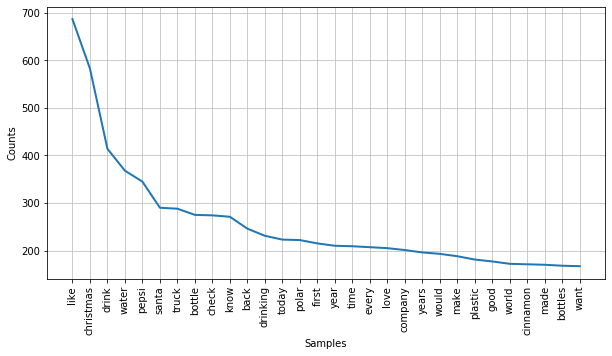

,Frequency
Term,
like,687
christmas,583
drink,414
water,368
pepsi,345
santa,290
truck,288
bottle,275
check,274


In [12]:
common_words(coca_cola)

#####  

##### Word Cloud - Coca Cola

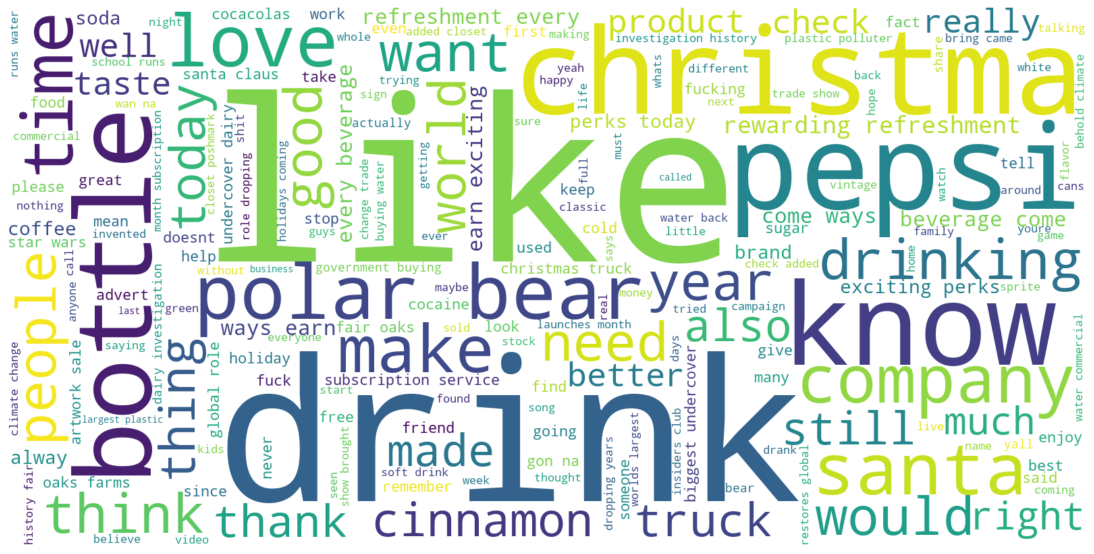

In [13]:
wordCloud(coca_cola,coca_cola_stop_words)

##### Sentimental Analysis - Coca Cola

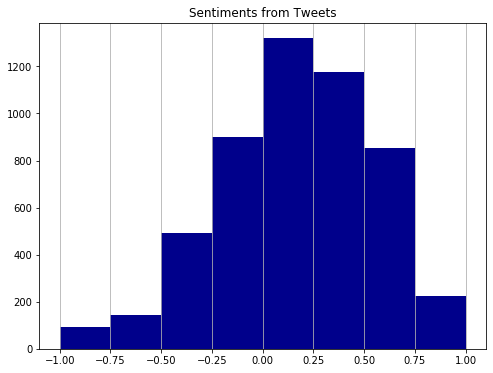

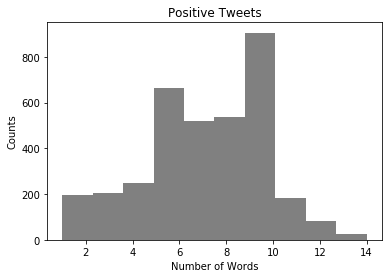

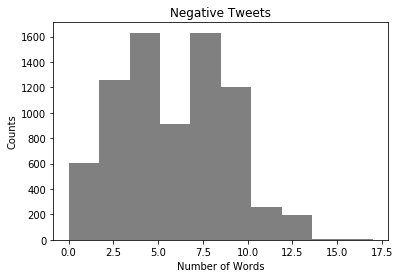

In [58]:
sentimentalAnalysis(coca_cola)

##### Time Tweets - Coca Cola

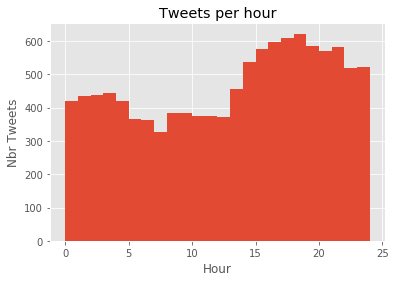

In [127]:
timeTweets(coca_cola)

### APPLE

In [15]:
# Getting tweets from Apple

apple=get_tweets("#Apple", "2019-12-01")

In [16]:
apple.head()

,user,created_at,text,location,retweet_count,favorite_count
0,pcexpander,2019-12-19 12:04:21,Apple HomeKit Open Source ADK accelera lo svil...,"Palermo, Sicilia",0,0
1,appleinsider,2019-12-19 12:02:19,#Apple is looking at ways to include sensors i...,"Cupertino, California",2,6
2,_iblobl,2019-12-19 12:02:02,#Practice #addition the #FUN way! You do the #...,"Grimsby, England",0,0
3,workishwork,2019-12-19 12:01:36,Today's Best Practice. #tech #apple #iphone #w...,,0,0
4,Afford_Learning,2019-12-19 12:01:29,Did you know….. Apples are more effective ...,South Africa,0,1


##### Cleanning Process - Apple

In [17]:
apple_stop_words=['apple','dont','thats','could','isnt','arent','didnt','cant','theres', 'apples']
apple=cleaning_data(apple,apple_stop_words)

In [18]:
apple.head()

,user,created_at,text,location,retweet_count,favorite_count,text_clean
0,pcexpander,2019-12-19 12:04:21,Apple HomeKit Open Source ADK accelera lo svil...,"Palermo, Sicilia",0,0,homekit open source accelera sviluppo disposit...
1,appleinsider,2019-12-19 12:02:19,#Apple is looking at ways to include sensors i...,"Cupertino, California",2,6,looking ways include sensors stylus provide ha...
2,_iblobl,2019-12-19 12:02:02,#Practice #addition the #FUN way! You do the #...,"Grimsby, England",0,0,practice addition mathsgames mathematics
3,workishwork,2019-12-19 12:01:36,Today's Best Practice. #tech #apple #iphone #w...,,0,0,todays best practice tech iphone waterproof
4,Afford_Learning,2019-12-19 12:01:29,Did you know….. Apples are more effective ...,South Africa,0,1,know effective waking morning coffee vsdidyouknow


##### Common Words - Apple

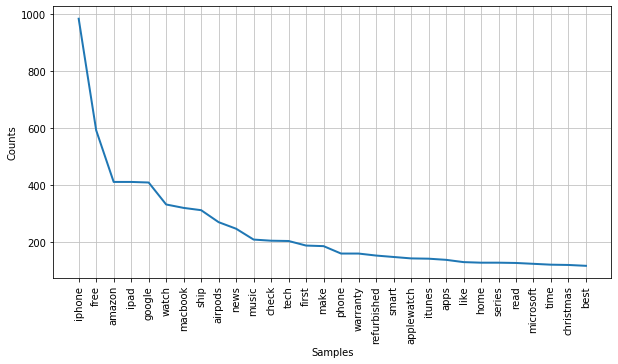

,Frequency
Term,
iphone,984
free,593
ipad,412
amazon,412
google,410
watch,333
macbook,321
ship,313
airpods,271


In [19]:
common_words(apple)

##### Word Cloud - Apple

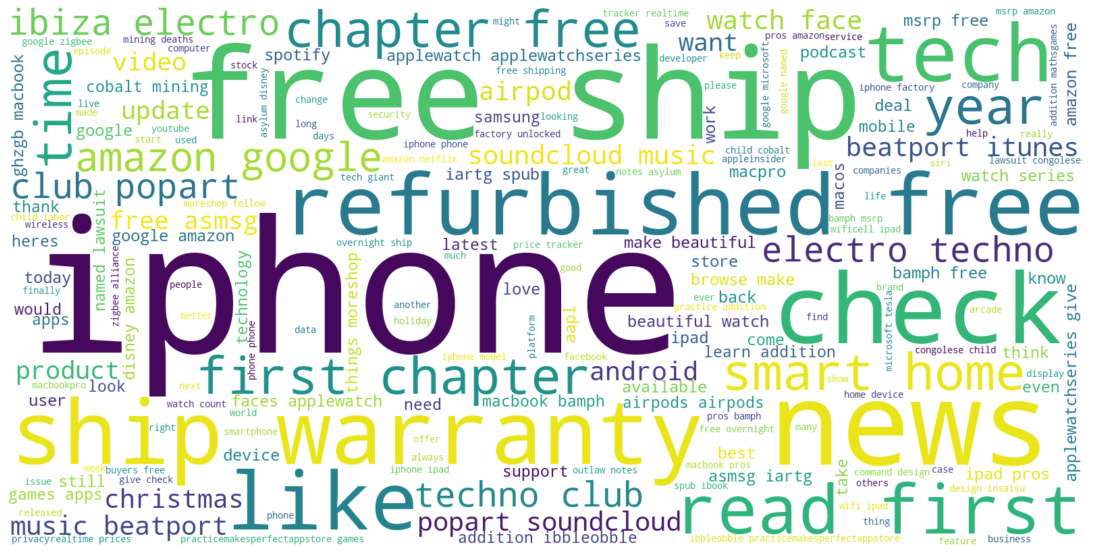

In [20]:
wordCloud(apple,apple_stop_words)

##### Sentimental Analysis - Apple

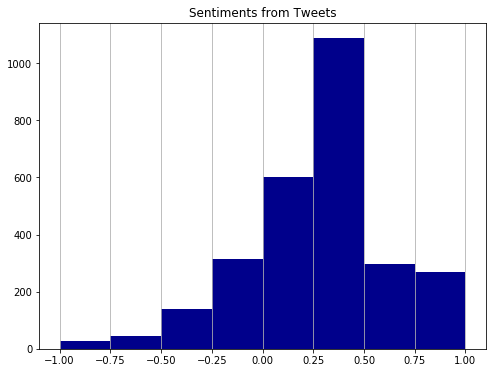

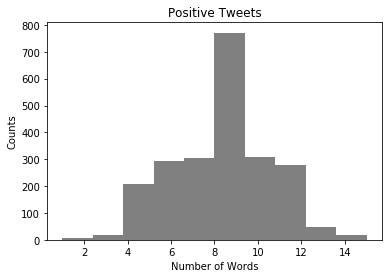

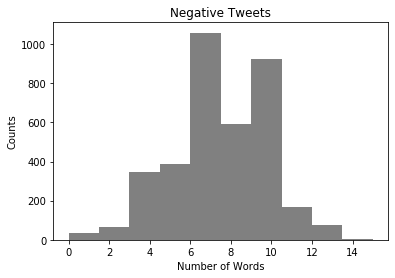

In [59]:
sentimentalAnalysis(apple)

##### Time Tweets -  Apple

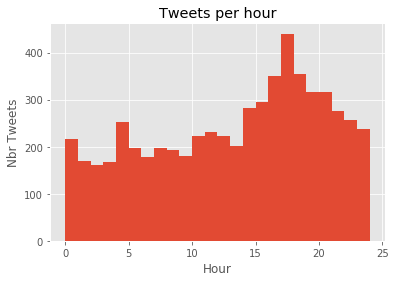

In [128]:
timeTweets(apple)

### UNILEVER

In [29]:
# Getting tweets from Unilever

unilever=get_tweets("Unilever", "2019-12-01")

In [30]:
unilever.head()

,user,created_at,text,location,retweet_count,favorite_count
0,JaccoJackson,2019-12-19 13:19:39,"Pelosi calls for fair Senate trial, does not r...","Lagos, nigeria",0,0
1,Ethical_Corp,2019-12-19 12:59:14,"A year after he left Unilever, @Ethical_Corp e...","London, UK",0,0
2,sdgcounting,2019-12-19 12:58:05,India's $62 billion sanitation economy is fuel...,,0,0
3,jarredcinman,2019-12-19 12:55:03,@MxolisiBob Unilever is a multinational which ...,"Johannesburg, South Africa",0,0
4,TristanHaggard,2019-12-19 12:54:54,@lowcarbfast @LouiseStephen9 Grassroots Unilev...,Ecuador,0,1


##### Cleanning Process - Unilever

In [35]:
unilever_stop_words=['dont','thats','could','isnt','arent','didnt','cant','theres','Unilever','unilever', 'unilevers']
unilever=cleaning_data(unilever,unilever_stop_words)

In [36]:
unilever.head()

,user,created_at,text,location,retweet_count,favorite_count,text_clean
0,JaccoJackson,2019-12-19 13:19:39,"Pelosi calls for fair Senate trial, does not r...","Lagos, nigeria",0,0,pelosi calls fair senate trial reject withhold...
1,Ethical_Corp,2019-12-19 12:59:14,"A year after he left Unilever, @Ethical_Corp e...","London, UK",0,0,year left editor terry slavin interviews
2,sdgcounting,2019-12-19 12:58:05,India's $62 billion sanitation economy is fuel...,,0,0,indias billion sanitation economy fueling entr...
3,jarredcinman,2019-12-19 12:55:03,@MxolisiBob Unilever is a multinational which ...,"Johannesburg, South Africa",0,0,multinational means head office ultimately rol...
4,TristanHaggard,2019-12-19 12:54:54,@lowcarbfast @LouiseStephen9 Grassroots Unilev...,Ecuador,0,1,grassroots kraft cargill bayermonsanto want sa...


##### Common Words - Unilever

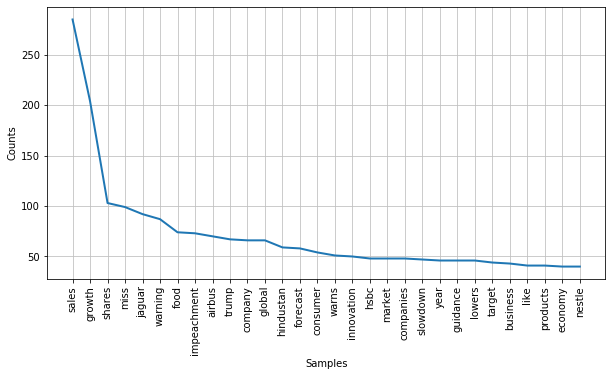

,Frequency
Term,
sales,285
growth,204
shares,103
miss,99
jaguar,92
warning,87
food,74
impeachment,73
airbus,70


In [37]:
common_words(unilever)

##### Word Cloud - Unilever

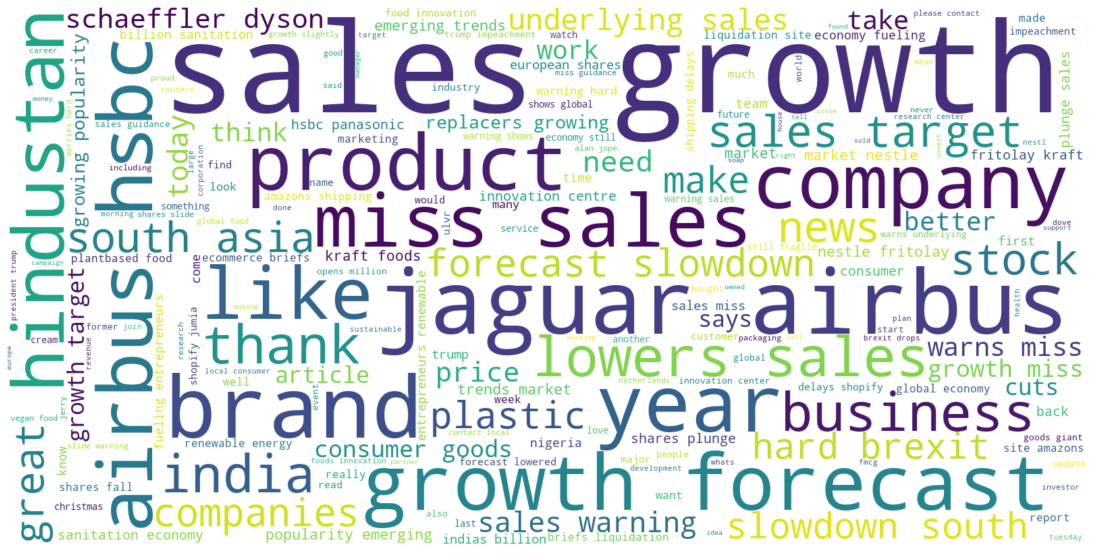

In [38]:
wordCloud(unilever,unilever_stop_words)

##### Sentimental Analysis - Unilever

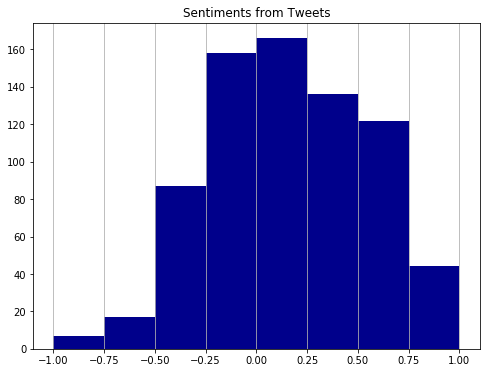

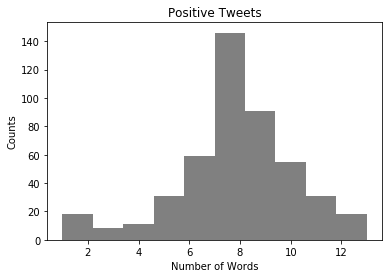

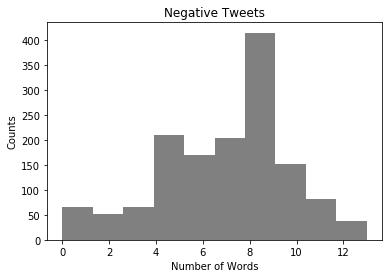

In [60]:
sentimentalAnalysis(unilever)

##### Time Tweets - Unilever

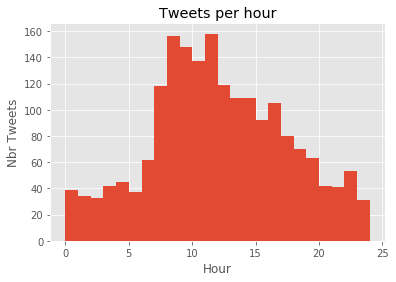

In [129]:
timeTweets(unilever)

##### Exporting Data to CSV file

In [122]:
coca_cola.to_csv(r'C:\Users\azambranollano\OneDrive - IESEG\Alejandra\Financial Programming\Individual Project\coca_cola.csv')

In [123]:
apple.to_csv(r'C:\Users\azambranollano\OneDrive - IESEG\Alejandra\Financial Programming\Individual Project\apple.csv')

In [124]:
unilever.to_csv(r'C:\Users\azambranollano\OneDrive - IESEG\Alejandra\Financial Programming\Individual Project\unilever.csv')